In [1]:
import numpy as np
import pyranges as pr
import pandas
import seaborn
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scarlink.src.visualization as scv

In [2]:
# make tmp directory
os.makedirs("./tmp/", exist_ok=True)
os.makedirs("./scarlink_outs/", exist_ok=True)

### Download data files and SCARlink models from figshare

In [3]:
# PBMC
!( \
if [ ! -d ./scarlink_outs/pbmc_all_out_10k ]; then \
cd ./scarlink_outs; \
wget https://figshare.com/ndownloader/files/44297825?private_link=9b9e89ff3150aebb6d7a -O ./pbmc_all_out_10k.zip; \
unzip pbmc_all_out_10k.zip; rm pbmc_all_out_10k.zip; \
fi)

In [4]:
# Data files
!( \
if [ ! -d ./fig_data ]; then \
wget https://figshare.com/ndownloader/files/44312828?private_link=9b9e89ff3150aebb6d7a -O ./fig_data.zip; \
unzip fig_data.zip; rm fig_data.zip; \
fi)

Read in files from `fig_data` directory:

In [5]:
peaks = pandas.read_csv('./fig_data/all_peak_set.csv.gz', sep='\t') # PBMC peak coordinates obtained using ArchR
pchic_table = pandas.read_csv('./fig_data/SuppTbl2.csv.gz', sep=',') # Supplementary table from SCARlink paper

Read in SCARlink predictions of gene-linked tile. This can be generated by running SCARlink on 10x PBMC multiome.

In [6]:
# We ran scarlink and then scarlink_tiles to generate gene-linked tile CSV file
pbmc_scarlink_out = "./scarlink_outs/pbmc_all_out_10k/"
tbl = pandas.read_csv(pbmc_scarlink_out + "./gene_linked_tiles_celltype.csv.gz", sep='\t')

In [7]:
def get_hist(df):

    df_subsampled = pandas.DataFrame(columns=df.columns)
    
    for c in df['celltype'].unique():
        df_c = df[df['celltype']==c]
        df_c_sig = df_c[df_c['pchic_significant']==True]
        sig = np.histogram(df_c_sig['test_acc'].values, bins=5, #5, #25,
             range=(df_c_sig['test_acc'].values.min(), 
                df_c_sig['test_acc'].values.max()))
        df_c_insig = df_c[df_c['pchic_significant']==False]
        insig = np.histogram(df_c_insig['test_acc'].values, bins=5, #5, #25,
             range=(df_c_sig['test_acc'].values.min(), 
                df_c_sig['test_acc'].values.max()))
        
        # sample values
        for i in range(sig[0].shape[0]):
            df_c_sig_sub = df_c_sig[(df_c_sig['test_acc'] >= sig[1][i]) & (df_c_sig['test_acc'] < sig[1][i+1])]
            df_c_insig_sub = df_c_insig[(df_c_insig['test_acc'] >= sig[1][i]) & (df_c_insig['test_acc'] < sig[1][i+1])]

            n_sig_bins = df_c_sig_sub.shape[0] # sig[0][i]
            n_insig_bins = df_c_insig_sub.shape[0] # insig[0][i]
            
            if 1==2: 
                df_subsampled = pandas.concat([df_subsampled, df_c_sig_sub, df_c_insig_sub])
                continue
            else:
                n_bins = min(n_sig_bins, n_insig_bins)
                if n_bins == 0: 
                    print(n_sig_bins, n_insig_bins)
                    #df_subsampled = pandas.concat([df_subsampled, df_c_sig_sub, df_c_insig_sub])
                    continue
                df_c_sig_sub  = df_c_sig_sub.sample(n=n_bins, replace=False, random_state=9).copy()
                df_c_insig_sub  = df_c_insig_sub.sample(n=n_bins, replace=False, random_state=9).copy()
                df_subsampled = pandas.concat([df_subsampled, df_c_sig_sub, df_c_insig_sub])
                
    return df_subsampled

In [8]:
def plot_df_all_peaks_subsampled(tbl, peaks, pchic_table, outfile=""):
    pchic_table = pchic_table.merge(tbl[['chr', 'start', 'end', 'gene', 'celltype', 'test_acc']], 
                                   on=['chr', 'start', 'end', 'gene', 'celltype'])
    
    flierprops = dict(marker='.', markersize=1,  color='black', alpha=0.5)
    pchic_pr = pr.PyRanges(pchic_table.rename(columns={'chr': 'Chromosome',
                                                  'start': 'Start',
                                                  'end': 'End'}))
    peaks_pr = pr.PyRanges(peaks.rename(columns={'seqnames': 'Chromosome',
                                                  'start': 'Start',
                                                  'end': 'End'}))
    pchic_df = pchic_pr.count_overlaps(peaks_pr, overlap_col='peak_overlap').as_df()

    median_peaks_10 = np.percentile(pchic_df[pchic_df['peak_overlap'] > 0]['test_acc'], 10)
    pchic_df = pchic_df[(pchic_df['test_acc'] > median_peaks_10)].copy() # median_peaks_25)].copy()
    
    sig_pchic = pchic_df[['celltype', 'gene', 'z-score', 'pchic_significant',
            'pchic_coordinate', 'test_acc']][pchic_df['pchic_significant']==True].groupby(['celltype', 
                                    'gene', 'pchic_coordinate']).max().reset_index()
    nonsig_pchic = pchic_df[['celltype', 'gene', 'z-score', 'pchic_significant',
            'pchic_coordinate', 'test_acc']][pchic_df['pchic_significant']==False].groupby(['celltype', 
                                    'gene', 'pchic_coordinate']).max().reset_index()
    
    df = pandas.concat([sig_pchic, nonsig_pchic])
    df = get_hist(df)
    
    plt.figure(figsize=(12, 5))
    boxes = seaborn.boxplot(data=df, x='celltype', y="z-score", hue="pchic_significant", 
                            flierprops=flierprops, notch=True,
                           palette=['dimgrey', 'lightgrey'], 
            order=['CD4 Naive', 'CD8 Naive', 'CD14+ Monocytes', 'B cells'],
                           hue_order=[True, False])
    colors = ['red', 'green', 'yellow', 'blue', 'orange', 'darkred', 'darkgreen', 'lightyellow', 'darkblue', 'darkorange']
    plt.legend(frameon=False)
    #colors = ['red', '#D51F26', 'yellow', '#D51F26', '#FEE500', '#FEE500', '#208A42', '#208A42', 
    #          '#F47D2B', '#F47D2B']

    #colors = ['red', '#208A42', 'yellow', '#208A42', '#F47D2B', '#F47D2B', '#FEE500', '#FEE500', 
    #          '#D51F26', '#D51F26']
    #colors = ['red', '#208A42', 'yellow', '#208A42', '#F47D2B', '#F47D2B', '#FEE500', '#FEE500', 
    #          '#D51F26', '#D51F26']

    colors = ['#208A42', '#208A42', '#F47D2B', '#F47D2B', '#FEE500', '#FEE500', 
                  '#D51F26', '#D51F26', '#D51F26', '#D51F26']
    '''
    p_color = ''
    for i,thisbar in enumerate(boxes.patches):
        #if colors[i] == 'red': continue
        print(i)
        print(thisbar)
        print(p_color, colors[i])
        thisbar.set_color(colors[i])
        if p_color == colors[i]: thisbar.set(alpha=0.5)
        p_color = colors[i]
        thisbar.set_edgecolor("black")
    '''
    plt.gca().set(yscale="log")
    ylims = plt.gca().get_ylim()
    plt.gca().set_ylim((ylims[0], 1e3))
    plt.tight_layout()
    if outfile != "":
        plt.savefig(outfile, transparent=True)
    plt.show()
    plt.close()
    
    for celltype in ['CD4 Naive', 'CD8 Naive', 'CD14+ Monocytes', 'B cells']:
        df_c = df[df['celltype']==celltype]
        _, pv = mannwhitneyu(df_c[df_c['pchic_significant']==True]['z-score'].values, 
                      df_c[df_c['pchic_significant']==False]['z-score'].values, 
                      alternative='greater')

        print(celltype, pv)
    df.to_csv('./tmp/pchic_boxplot.csv', sep='\t', index=None)

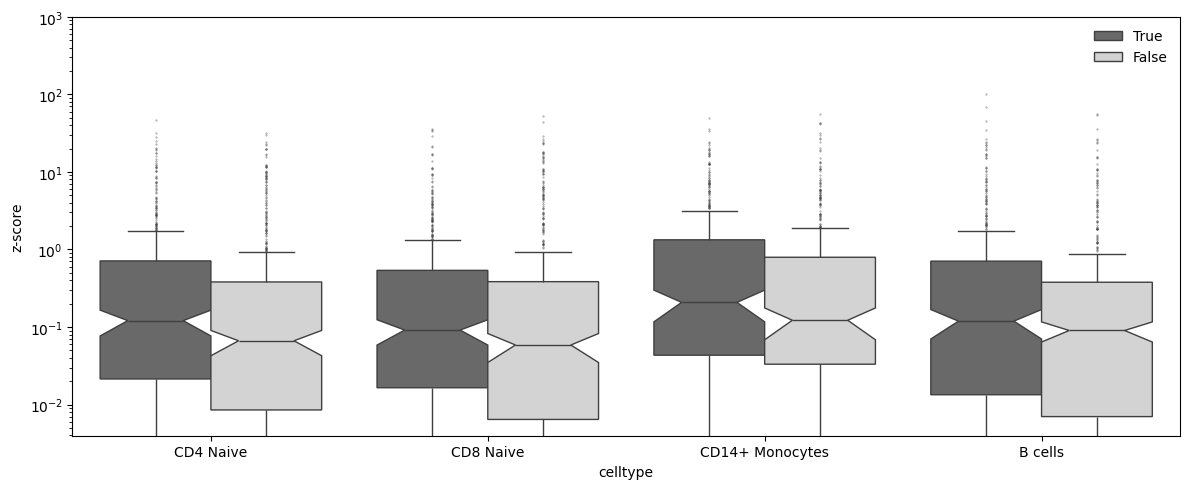

CD4 Naive 0.0011720270164210602
CD8 Naive 0.020402589554178435
CD14+ Monocytes 0.003142494769019495
B cells 0.004988589344227235


In [9]:
plot_df_all_peaks_subsampled(tbl, peaks, pchic_table)

## Plot SCARlink output

Saved as ./scarlink_outs/pbmc_all_out_10k/scarlink_plots/HLA-DQB1.png


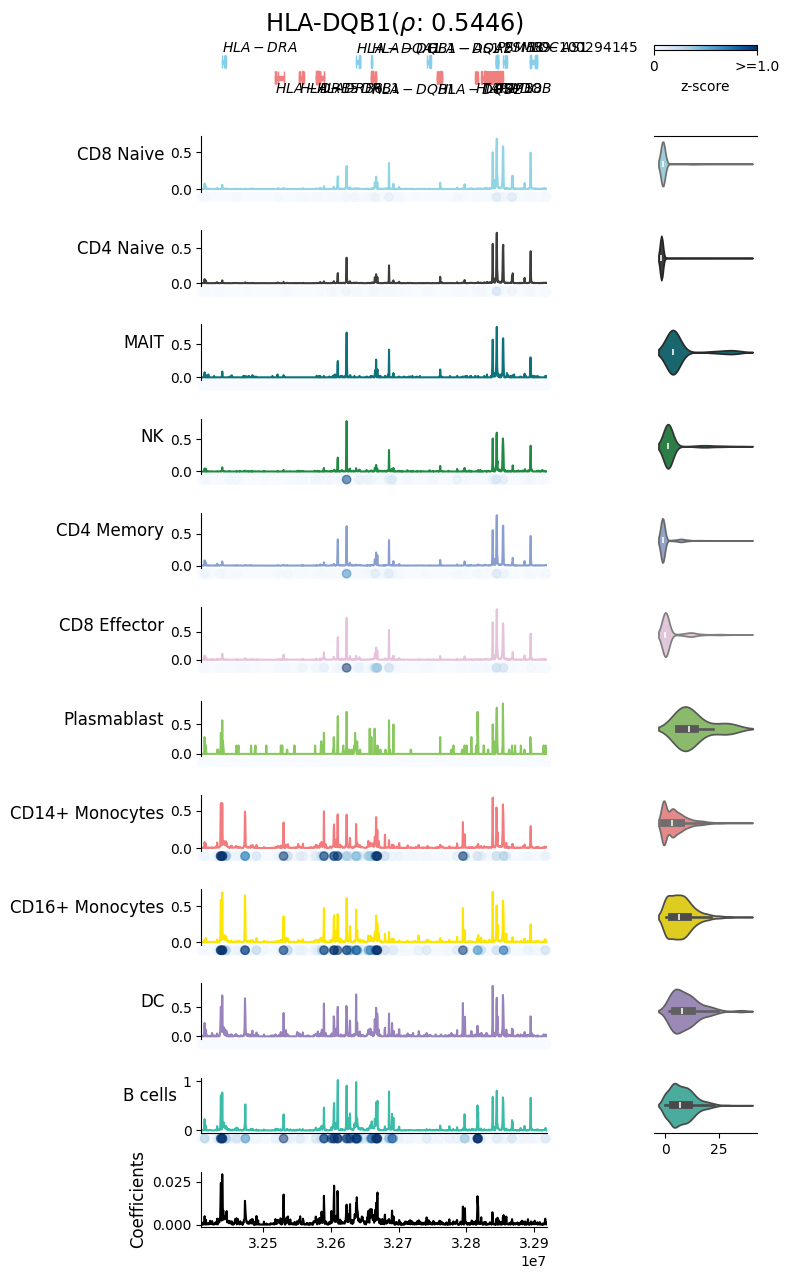

In [10]:
scarlink_out_pbmc = scv.get_scarlink_output(pbmc_scarlink_out)
scv.plot_scarlink_output(scarlink_out_pbmc, genes=['HLA-DQB1'], celltype='celltype', figsize=(8, 13), 
                        show_yticks=True)
plt.tight_layout()

### Arc plot

In [11]:
import pandas
import os
import coolbox
from coolbox.api import *

In [12]:
pchic_table = pandas.read_csv('./fig_data/SuppTbl2.csv.gz', sep=',') # Supplementary table from SCARlink paper

In [13]:
hla_dqb1_chr = 'chr6'
hla_dqb1_promoter_start = 32665661
hla_dqb1_promoter_end = 32669176
hla_dqb1_promoter_mid = (hla_dqb1_promoter_start + hla_dqb1_promoter_end)//2

In [14]:
def create_bedfile(tbl, celltype, chrm, p_mid, line_color):
    coords = tbl[(tbl['gene']=='HLA-DQB1') & (tbl['celltype']==celltype) & 
            (tbl['pchic_significant'])]['pchic_coordinate'].values
    starts = [int(i.split(':')[1].split('-')[0]) for i in coords]
    ends = [int(i.split(':')[1].split('-')[1]) for i in coords]
    df = pandas.DataFrame(columns=['chr_1', 'start_1', 'end_1', 'chr_2', 'start_2', 'end_2'])
    df['start_2'] = starts
    df['end_2'] = ends
    df['chr_1'] = chrm
    df['chr_2'] = chrm
    df['start_1'] = p_mid
    df['end_1'] = p_mid + 1
    df['value'] = 1
    os.makedirs('./tmp', exist_ok=True)
    filename = './tmp/pbmc_' + '_'.join(celltype.split()) + '.arcs'
    df.to_csv(filename, index=None, header=False, sep='\t')
    print("Saved: " + filename)
    
    filename_ini = './tmp/pbmc_' + '_'.join(celltype.split()) + '.ini'
    f = open(filename_ini, 'w')
    f.write("[test arcs]\n" + 
    "file = " + filename + "\n" + 
    "title = links orientation = inverted\n" + 
    "orientation = inverted\n" + 
    "color = " + line_color + "\n" + 
    "line_width = 0.08\n" +  
    "height = 2\n\n" + 
    "[x-axis]\n")
    f.close()
    
    print("Saved: " + filename_ini)

In [15]:
create_bedfile(pchic_table, 'CD4 Naive', hla_dqb1_chr, hla_dqb1_promoter_mid,
               line_color="#208A42")
create_bedfile(pchic_table, 'CD8 Naive', hla_dqb1_chr, hla_dqb1_promoter_mid,
               line_color="#F47D2B")
create_bedfile(pchic_table, 'CD14+ Monocytes', hla_dqb1_chr, hla_dqb1_promoter_mid,
               line_color="#FEE500")
create_bedfile(pchic_table, 'B cells', hla_dqb1_chr, hla_dqb1_promoter_mid,
               line_color="#D51F26")

Saved: ./tmp/pbmc_CD4_Naive.arcs
Saved: ./tmp/pbmc_CD4_Naive.ini
Saved: ./tmp/pbmc_CD8_Naive.arcs
Saved: ./tmp/pbmc_CD8_Naive.ini
Saved: ./tmp/pbmc_CD14+_Monocytes.arcs
Saved: ./tmp/pbmc_CD14+_Monocytes.ini
Saved: ./tmp/pbmc_B_cells.arcs
Saved: ./tmp/pbmc_B_cells.ini


In [16]:
!pyGenomeTracks --tracks ./tmp/pbmc_CD4_Naive.ini --region chr6:32409000-32918500 -o tmp/pbmc_hla_dqb1_CD4_Naive.pdf

INFO:pygenometracks.tracksClass:initialize 1. [test arcs]
100%|████████████████████████████████████████| 59/59 [00:00<00:00, 44111.22it/s]
INFO:pygenometracks.tracksClass:initialize 2. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04964804649353027
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 4.122340425531915. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [test arcs]
DEBUG:pygenometracks.tracks.GenomeTrack:11 were links plotted
INFO:pygenometracks.tracksClass:plotting 2. [x-axis]


In [17]:
!pyGenomeTracks --tracks ./tmp/pbmc_CD8_Naive.ini --region chr6:32409000-32918500 -o tmp/pbmc_hla_dqb1_CD8_Naive.pdf

INFO:pygenometracks.tracksClass:initialize 1. [test arcs]
100%|████████████████████████████████████████| 97/97 [00:00<00:00, 99037.85it/s]
INFO:pygenometracks.tracksClass:initialize 2. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.009866714477539062
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 4.122340425531915. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [test arcs]
DEBUG:pygenometracks.tracks.GenomeTrack:16 were links plotted
INFO:pygenometracks.tracksClass:plotting 2. [x-axis]


In [18]:
!pyGenomeTracks --tracks ./tmp/pbmc_CD14+_Monocytes.ini --region chr6:32409000-32918500 -o tmp/pbmc_hla_dqb1_CD14+_Monocytes.pdf

INFO:pygenometracks.tracksClass:initialize 1. [test arcs]
100%|██████████████████████████████████████| 106/106 [00:00<00:00, 86581.54it/s]
INFO:pygenometracks.tracksClass:initialize 2. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.0210878849029541
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 4.122340425531915. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [test arcs]
DEBUG:pygenometracks.tracks.GenomeTrack:16 were links plotted
INFO:pygenometracks.tracksClass:plotting 2. [x-axis]


In [19]:
!pyGenomeTracks --tracks ./tmp/pbmc_B_cells.ini --region chr6:32409000-32918500 -o tmp/pbmc_hla_dqb1_B_cells.pdf

INFO:pygenometracks.tracksClass:initialize 1. [test arcs]
100%|█████████████████████████████████████| 163/163 [00:00<00:00, 121261.36it/s]
INFO:pygenometracks.tracksClass:initialize 2. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.008963346481323242
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 4.122340425531915. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [test arcs]
DEBUG:pygenometracks.tracks.GenomeTrack:20 were links plotted
INFO:pygenometracks.tracksClass:plotting 2. [x-axis]
